# Learn Pytorch Lightning Tutorial

## Create a simple NN with only Pytorch

First we will create and train a simple NN only with Pytorch. Then we will repeat the same procedures with Pytorch Lightning.

In [31]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD

import lightning as L
# For Lighting version 2.x
from lightning.pytorch.tuner import Tuner
from torch.utils.data import TensorDataset, DataLoader

import matplotlib.pyplot as plt
import seaborn as sns

In [32]:
# Assume the model parameters have already been optimised by back propagation (pre-trained)
class BasicNN(nn.Module):

    def __init__(self):
        
        super().__init__()

        self.w00 = nn.Parameter(torch.tensor(1.7), requires_grad=False)
        self.b00 = nn.Parameter(torch.tensor(-0.85), requires_grad=False)
        self.w01 = nn.Parameter(torch.tensor(-40.8), requires_grad=False)

        self.w10 = nn.Parameter(torch.tensor(12.6), requires_grad=False)
        self.b10 = nn.Parameter(torch.tensor(0.0), requires_grad=False)
        self.w11 = nn.Parameter(torch.tensor(2.7), requires_grad=False)

        self.final_bias = nn.Parameter(torch.tensor(-16.0), requires_grad=False)

    def forward(self, input):

        input_to_top_relu = input * self.w00 + self.b00
        top_relu_output = F.relu(input_to_top_relu)
        scaled_top_relu_output = top_relu_output * self.w01

        input_to_bottom_relu = input * self.w10 + self.b10
        bottom_relu_output = F.relu(input_to_bottom_relu)
        scaled_bottom_relu_output = bottom_relu_output * self.w11

        input_to_final_relu =  scaled_top_relu_output + scaled_bottom_relu_output + self.final_bias
        output = F.relu(input_to_final_relu)

        return output

In [33]:
# Create input values to test the model
input_doses = torch.linspace(0, 1, steps=11)
input_doses

tensor([0.0000, 0.1000, 0.2000, 0.3000, 0.4000, 0.5000, 0.6000, 0.7000, 0.8000,
        0.9000, 1.0000])

In [34]:
# Create an instance of the model class
model = BasicNN()
output_values = model(input_doses)
output_values

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0100, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000])

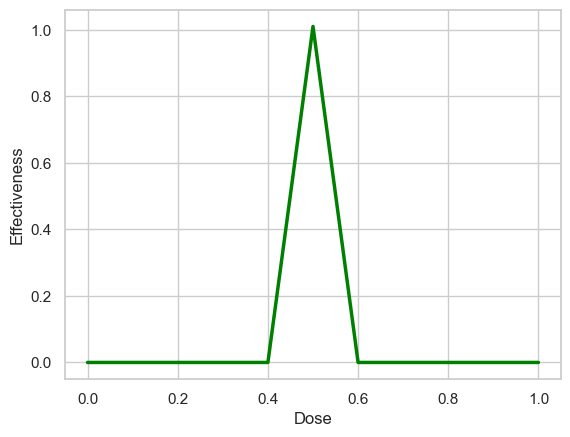

In [35]:
# Set up the style of seaborn
sns.set_theme(style="whitegrid")
sns.lineplot(x=input_doses,
             y=output_values,
             color="green",
             linewidth=2.5)

plt.ylabel("Effectiveness")
plt.xlabel("Dose");

## Train a parameter with only PyTorch

Tweak the value of `final_bias` (by setting it to 0) and then try to optimize it via training.

In [36]:
class BasicNNTrain(nn.Module):

    def __init__(self):
        
        super().__init__()

        self.w00 = nn.Parameter(torch.tensor(1.7), requires_grad=False)
        self.b00 = nn.Parameter(torch.tensor(-0.85), requires_grad=False)
        self.w01 = nn.Parameter(torch.tensor(-40.8), requires_grad=False)

        self.w10 = nn.Parameter(torch.tensor(12.6), requires_grad=False)
        self.b10 = nn.Parameter(torch.tensor(0.0), requires_grad=False)
        self.w11 = nn.Parameter(torch.tensor(2.7), requires_grad=False)

        # Setting the bias to 0 so that we can improve it by training the model
        self.final_bias = nn.Parameter(torch.tensor(0.0), requires_grad=True)

    def forward(self, input):

        input_to_top_relu = input * self.w00 + self.b00
        top_relu_output = F.relu(input_to_top_relu)
        scaled_top_relu_output = top_relu_output * self.w01

        input_to_bottom_relu = input * self.w10 + self.b10
        bottom_relu_output = F.relu(input_to_bottom_relu)
        scaled_bottom_relu_output = bottom_relu_output * self.w11

        input_to_final_relu =  scaled_top_relu_output + scaled_bottom_relu_output + self.final_bias
        output = F.relu(input_to_final_relu)

        return output

In [37]:
# See the impact to the model with an unoptimized parameter
model = BasicNNTrain()
output_values = model(input_doses)
output_values

tensor([ 0.0000,  3.4020,  6.8040, 10.2060, 13.6080, 17.0100, 13.4760,  9.9420,
         6.4080,  2.8740,  0.0000], grad_fn=<ReluBackward0>)

Text(0.5, 0, 'Dose')

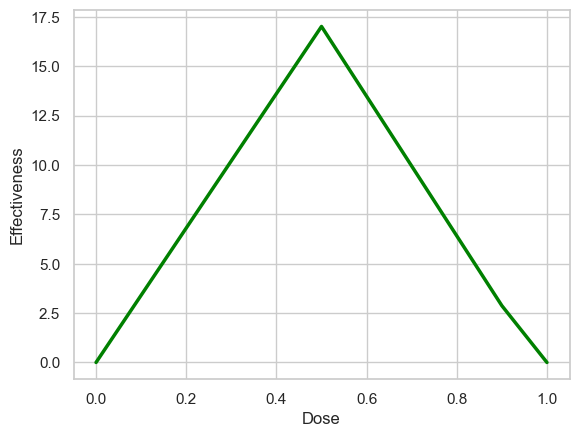

In [38]:
# Set up the style of seaborn
sns.set_theme(style="whitegrid")
sns.lineplot(x=input_doses,
             # Detach the output because the require_grad parameter of final_bias is set to True
             y=output_values.detach(),
             color="green",
             linewidth=2.5)

plt.ylabel("Effectiveness")
plt.xlabel("Dose")

In [39]:
# Create training data
inputs = torch.tensor([0. ,0.5, 1.])
labels = torch.tensor([0., 1., 0.])
inputs, labels, inputs.dtype, labels.dtype

(tensor([0.0000, 0.5000, 1.0000]),
 tensor([0., 1., 0.]),
 torch.float32,
 torch.float32)

In [40]:
## Setup the optimizer
optimizer = SGD(model.parameters(), lr=0.1)

In [41]:
print(f"Final bias, before optimization: {model.final_bias.data}\n")

# Create the training loop
for epoch in range(100):

    total_loss = 0

    # Iterating over one sample (instead of a batch) at a time
    for iteration in range(len(inputs)):
        
        input_i, label_i = inputs[iteration], labels[iteration]
        # Get the model prediction
        output_i = model(input_i)
        
        loss = (output_i - label_i)**2
        loss.backward()
        # Convert loss from tensor to float
        total_loss += float(loss)

    # Print out the training loss per epoch
    print(f"Training loss: {total_loss:.4f}\n")
    
    # Stopping criteria
    if (total_loss < 0.0001):
        break

    optimizer.step()
    optimizer.zero_grad()

print(f"Final bias, after optimization: {model.final_bias.data}")    
    

Final bias, before optimization: 0.0

Training loss: 256.3201

Training loss: 164.0449

Training loss: 104.9887

Training loss: 67.1928

Training loss: 43.0034

Training loss: 27.5222

Training loss: 17.6142

Training loss: 11.2731

Training loss: 7.2148

Training loss: 4.6175

Training loss: 2.9552

Training loss: 1.8913

Training loss: 1.2104

Training loss: 0.7747

Training loss: 0.4958

Training loss: 0.3173

Training loss: 0.2031

Training loss: 0.1300

Training loss: 0.0832

Training loss: 0.0532

Training loss: 0.0341

Training loss: 0.0218

Training loss: 0.0140

Training loss: 0.0089

Training loss: 0.0057

Training loss: 0.0037

Training loss: 0.0023

Training loss: 0.0015

Training loss: 0.0010

Training loss: 0.0006

Training loss: 0.0004

Training loss: 0.0003

Training loss: 0.0002

Training loss: 0.0001

Training loss: 0.0001

Final bias, after optimization: -16.001882553100586


## Train the model with Pytorch + Lightning

In [42]:
class BasicLightningTrain(L.LightningModule):

    def __init__(self):
        
        super().__init__()

        self.w00 = nn.Parameter(torch.tensor(1.7), requires_grad=False)
        self.b00 = nn.Parameter(torch.tensor(-0.85), requires_grad=False)
        self.w01 = nn.Parameter(torch.tensor(-40.8), requires_grad=False)

        self.w10 = nn.Parameter(torch.tensor(12.6), requires_grad=False)
        self.b10 = nn.Parameter(torch.tensor(0.0), requires_grad=False)
        self.w11 = nn.Parameter(torch.tensor(2.7), requires_grad=False)

        self.final_bias = nn.Parameter(torch.tensor(0.0), requires_grad=True)

        # Set the learning rate to 0.1 right now as a placeholder, Lightning will adjust it for us during training
        self.learning_rate = 0.01

    def forward(self, input):

        input_to_top_relu = input * self.w00 + self.b00
        top_relu_output = F.relu(input_to_top_relu)
        scaled_top_relu_output = top_relu_output * self.w01

        input_to_bottom_relu = input * self.w10 + self.b10
        bottom_relu_output = F.relu(input_to_bottom_relu)
        scaled_bottom_relu_output = bottom_relu_output * self.w11

        input_to_final_relu =  scaled_top_relu_output + scaled_bottom_relu_output + self.final_bias
        output = F.relu(input_to_final_relu)

        return output
    
    # Configure the optimizer in Lightning style
    def configure_optimizers(self):
        # Lightning will improve the learning rate for us during training
        return SGD(model.parameters(), lr=self.learning_rate)
    
    # Simplied training loop in Lightning style
    def training_step(self, batch, batch_idx):
        input_i, label_i = batch
        output_i = self.forward(input_i)
        loss = (output_i - label_i)**2 

        return loss

In [43]:
from torch.utils.data import TensorDataset, DataLoader

# Create dataloader
dataset = TensorDataset(inputs, labels)
dataloader = DataLoader(dataset)
len(dataloader)

3

In [44]:
# Create an instance of the model
model = BasicLightningTrain()
model

BasicLightningTrain()

In [48]:
# Create an instance of a lightning trainer
trainer = L.Trainer(max_epochs=34, accelerator="auto", devices="auto") # accelerator="auto" detects available accelerators in your device and devices="auto" tells you how many of them are available

# Create a tuner 
tuner = Tuner(trainer)

lr_find_results = tuner.lr_find(model,
                                dataloader,
                                min_lr=0.001,
                                max_lr=0.1,
                                early_stop_threshold=None) # mini-batches might be noisy

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/edison/Git/pytorch-lightning-deep-learning/myenv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/Users/edison/Git/pytorch-lightning-deep-learning/myenv/lib/python3.11/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.0016595869074375606
Restoring states from the checkpoint path at /Users/edison/Git/pytorch-lightning-deep-learning/.lr_find_8fd59fc0-ba55-4d44-accf-f782c54d5d57.ckpt
Restored all states from the checkpoint at /Users/edison/Git/pytorch-lightning-deep-learning/.lr_find_8fd59fc0-ba55-4d44-accf-f782c54d5d57.ckpt


In [53]:
# lr_find_results.results # returns a dictionary of lr and loss

dict_keys(['lr', 'loss'])

In [55]:
new_lr = lr_find_results.suggestion()
print(f"The tuner suggests {new_lr:.5f} as the new learning rate.")

The tuner suggests 0.00166 as the new learning rate.


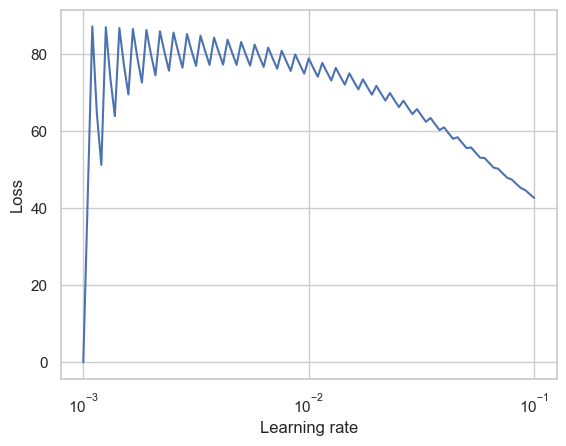

In [59]:
# You can also plot a curve of lr against loss
fig = lr_find_results.plot() # pick the lr at which the derivative is the most negative

In [60]:
# Use the learning rate suggested by the tuner 
model.learning_rate = new_lr

# Train the model
trainer.fit(model, train_dataloaders=dataloader)


  | Name         | Type | Params | Mode
---------------------------------------------
  | other params | n/a  | 7      | n/a 
---------------------------------------------
1         Trainable params
6         Non-trainable params
7         Total params
0.000     Total estimated model params size (MB)
/Users/edison/Git/pytorch-lightning-deep-learning/myenv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/Users/edison/Git/pytorch-lightning-deep-learning/myenv/lib/python3.11/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=34` reached.


In [61]:
print(f"Final bias, after optimization: {model.final_bias.data}") # further training is needed (the optimal value is -16)

Final bias, after optimization: -1.7112243175506592
